Tennis generates millions of dollars a year in revenue and is a source of entertainment for many around the world. The outcome of professional tennis matches can impact the amount of revenue generated by fans, tennis players, or individuals who bet on tennis matches. Like most sports, player rankings are used to compare the relative skill of the players and can have useful applications. In tennis, player rankings can be used to predict the outcome of matches or to sort players into “pools” with similar strength in tournaments. Being able to predict the ranking of these tennis matches could help us product the results of future tournaments which would be advantageous to many individuals in the professional tennis communities. Can we predict the ranking of a player in future tennis tournaments based on data from previous tennis matches? In order to build answer this question,  we will build a regression model using ATP Tennis Rankings, Results, and Stats data sourced from Jeff Sackmann, licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License. This dataset contains the results, statistics and rankings from the ATP tennis tournaments in 2017-2018. Our model will aim to predict the number of aces that a player will score in a hypothetical game based off of the following relevant predictors in the dataset: number of aces scored, rank points, age, and draw_size.



In [2]:
#Load necessary packages
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(ggplot2)
library("gridExtra")
library(GGally)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [3]:
#clean the data
match_data<-read_csv(file="atp2017-2019 (6).csv")
m_winner<-match_data|>
select(winner_rank,w_ace,winner_rank_points, winner_age,draw_size)
m_loser<-match_data|>
select(loser_rank,l_ace,loser_rank_points,loser_age,draw_size)

colnames(m_winner) <- c("rank","aces","rank_points","age","draw_size")
                            
colnames(m_loser) <- c("rank","aces","rank_points","age","draw_size")

matches<-rbind(m_loser,m_winner)|>

#mutate aces to be factor
mutate(rank=as.factor(rank))|>
#omit missing values
#omit missing values
na.omit()

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The data was cleaned by selecting only variables relevent for prediction. Additionally, the "winner" and "loser" seperation was removed, combining the data for winners and losers into one column. The responding variable (rank) was converted to a factor and any missing values were removed from the dataset for predictive purposes. 

In [4]:
#Split the data
set.seed(4321) 
match_splt <- initial_split(matches, prop = 3/4
                           , strata = aces)
match_train <- training(match_splt)
match_test <- testing(match_splt)

The data was split into a training and a testing set. The training set, containing 75% of our data, will be used to build and teach the model. The testing set, containing 25% of our data, will remain untouched during the model contruction and will only be used to test the model's accuracy after it has been built. Since we are working with a fairly large dataset (containing 13551 rows) we concluded at 25% was sufficient for the testing set, the training set contains a larger portion of data to give our model more to learn from.

##Preliminary Data Analysis

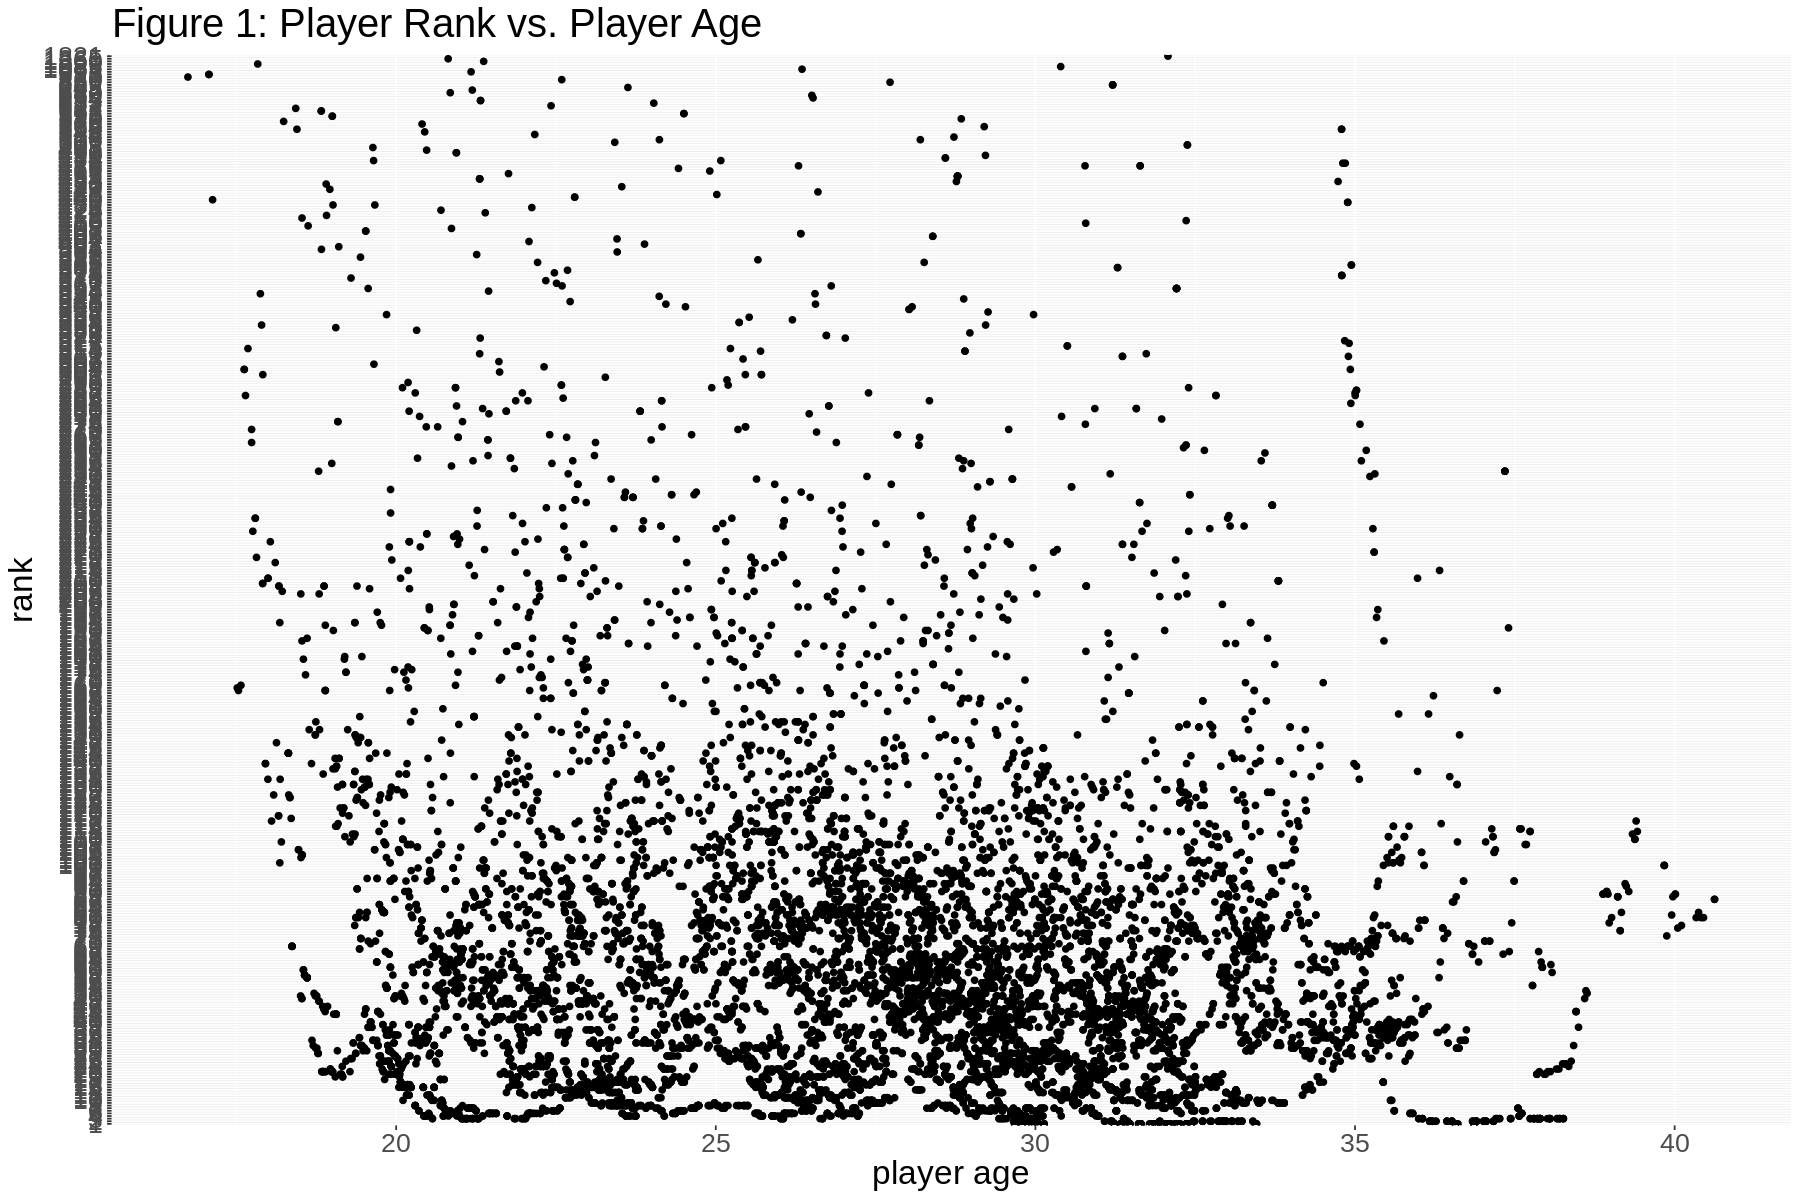

In [5]:
options(repr.plot.width = 15, repr.plot.height = 10) 

bounceRates_dist <- ggplot(match_train, aes(x =age, y=rank)) + 
                    geom_point() +    
                    labs(x = "player age", y = "rank", title = "Figure 1: Player Rank vs. Player Age") + 
                    theme(text = element_text(size = 20))


                   


bounceRates_dist

##predictive analysis

In [6]:
#creating recipe
tune_recipe<- recipe(rank ~ aces+rank_points+age+draw_size, data = match_train) |>
step_scale(all_predictors())|>
    step_center(all_predictors())
match_train

rank,aces,rank_points,age,draw_size
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
31,1,1298,19.86858,32
77,3,691,25.92471,32
131,3,433,19.33470,32
38,1,1083,29.54689,32
154,1,352,25.98494,32
75,1,701,23.26078,32
105,2,543,35.57563,32
47,0,985,26.61465,32
42,3,1045,30.50513,32


To built the recipe, rank was selected as the target variable while the predicting variables were specified as aces, rank points, age and draw size. The variables were scaled and centered to ensure that their mean was zero and their standard deviation was one.

In [7]:
# preform cross-validation
data_vfold <- vfold_cv(match_train, v = 5, strata = rank)

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


Cross validation helps us choose the k-value to maximizes the prediction accuracy of our model. The 5-fold method randomly divides the training dataset into 5 evenly sized subsets of data. One of the subsets (or folds) is used for validation while the remaining 4 compose the training set. The process is repeated 5 times, using all subsets to calulate the accuracy of each K-value on each subset, 


In [8]:
#tune model and fit to workflow
knn_tune<- nearest_neighbor(weight_func ="rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

#create data frame with K = [5, 10, 15, ... 100]
gridvals <- tibble(neighbors = seq(from = 5, to = 100, by = 5))
print("Table 1: Neighbors Used for Tuning the Model")
gridvals

[1] "Table 1: Neighbors Used for Tuning the Model"


neighbors
<dbl>
5
10
15
20
25
30
35
40
45


Seting the engine to "kknn" and the mode to "classification" specified the type of model we're building; K-nn classification. By setting the neighbors to "tune()" opposed to a specific number allows multiple k-values to be tested as once instead of just one. Our model tested every fifth value from 5-100 which provided a large range of K-values without drastically increasing the computation time.


In [ ]:
match_tune_res <- workflow() |>
                    add_recipe(tune_recipe) |> 
                    add_model(knn_tune)|> 
                    tune_grid(resamples = data_vfold, grid = gridvals)|>
                    collect_metrics()


The workflow is used to combine the recipe, model specificaton, model tuning and to collect the metrics. The tune_grid function was used to determine the accuracies of our model (in addition to mean and standard deviation) while the collect_metrics function collected these values together. The mean value corresponds to the estimated model accuracy while the standard error measures the magnitute of uncertainty surrounding the mean,.

In [ ]:
#plotting accuracy vs. number of neighbours

accuracies <- match_tune_res |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
print("Accuracy metrics arranged in descending order for various K-Values")
accuracies

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "neighbors (K-values)", y = "accuracy estimate", title = "model accuracy vs. number of neighbors used") +
    scale_x_continuous(breaks = seq(0, 100, by = 5)) +    
    theme(text = element_text(size = 20))
accuracy_versus_k

To visualize how the model accuracy varies across the various K-values, the accuracy metrics obtained from tuning where graphed against the K-values. In general, the accuracy of our model increased as K got larger, with a peak occuring at 

